## Analysis

In this notebook, we have a closer look on the dataset and try to find some interesting insights. We will try to find the relationship between datasets and how the moleucles within the dataset are related to each other.

Importtant datset characteristics:
- Number of training, validation and test tasks
- Number of molecules in each tasks (distribution/histogram of number of molecules in each task)
- Ratio of active to inactive molecules in each task (distribution/histogram of ratio of active to inactive molecules in each task)

## Importing libraries

In [1]:
import os
import argparse
import logging
import sys
from typing import List
import pickle
from dpu_utils.utils.richpath import RichPath

import torch
from tqdm import tqdm
import pandas as pd

# Setting up local details:
# This should be the location of the checkout of the FS-Mol repository:
FS_MOL_CHECKOUT_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol")
FS_MOL_DATASET_PATH = os.path.join("/data/local/apps/", "Meta-Learning", "FS-Mol", "datasets")

os.chdir(FS_MOL_CHECKOUT_PATH)
sys.path.insert(0, FS_MOL_CHECKOUT_PATH)

In [2]:
# import necessary modules from FS-Mol:
from fs_mol.data import FSMolDataset, DataFold

# import necessary modules from rdkit:
from rdkit import Chem
from rdkit.Chem import AllChem, Draw, PandasTools
from rdkit.Chem import MolFromSmiles
from rdkit.Chem.Scaffolds.MurckoScaffold import MurckoScaffoldSmilesFromSmiles

# import necessary modules for molecule visualization:
from ipywidgets import widgets
import mols2grid

# import necessary modules for dimensionality reduction:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# import necessary modules for featurzing molecules:
import datamol as dm
from molfeat.trans import MoleculeTransformer

# import necessary modules for visualization:
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
import pandas as pd


light_color = plt.get_cmap("plasma").colors[170]
dark_color = "black"


matplotlib.rcParams.update(
    {
        "pgf.texsystem": "pdflatex",
        "font.family": "serif",
        "font.serif": "Computer Modern Roman",
        "font.size": 20,
        "text.usetex": True,
        "pgf.rcfonts": False,
    }
)


## Extrcating Scaffold for FS-Mol Dataset

In [3]:
dataset = FSMolDataset.from_directory(FS_MOL_DATASET_PATH, task_list_file=os.path.join(FS_MOL_DATASET_PATH, "fsmol-0.1.json"))
# This will create a list of all tasks in the test tasks. Each task contains `MolculeDatapoint` object

test_tasks = []
# next line will create iterable object that will iterate over all tasks in the test dataset
print("reading test tasks ...")
test_task_iterable = dataset.get_task_reading_iterable(DataFold.TEST)
for task in tqdm(iter(test_task_iterable)):
    test_tasks.append(task)

print("reading train tasks ...")
train_tasks = []
train_task_iterable = dataset.get_task_reading_iterable(DataFold.TRAIN)
for task in tqdm(iter(train_task_iterable)):
    train_tasks.append(task)

reading test tasks ...


157it [00:11, 13.99it/s] 

reading train tasks ...



4938it [01:21, 60.40it/s] 


In [36]:
min_threshold = 156
max_threshold = 512
num_tasks_greater_than_threshold = 0
names=[]
for task in train_tasks:
    if (len(task.samples) > min_threshold and len(task.samples) < max_threshold):
        num_tasks_greater_than_threshold += 1
        names.append(task.name)


In [37]:
num_tasks_greater_than_threshold
names

['CHEMBL2219095',
 'CHEMBL2219008',
 'CHEMBL2219153',
 'CHEMBL1676103',
 'CHEMBL2219068',
 'CHEMBL3215188',
 'CHEMBL2219196',
 'CHEMBL2218982',
 'CHEMBL3887224',
 'CHEMBL1794491',
 'CHEMBL2219006',
 'CHEMBL2219219',
 'CHEMBL2219314',
 'CHEMBL2219136',
 'CHEMBL2219227',
 'CHEMBL2219085',
 'CHEMBL2219349',
 'CHEMBL2219216',
 'CHEMBL2219097',
 'CHEMBL2219084',
 'CHEMBL896689',
 'CHEMBL2218967',
 'CHEMBL1794355',
 'CHEMBL2218948',
 'CHEMBL2219390',
 'CHEMBL3721076',
 'CHEMBL2219064',
 'CHEMBL3214806',
 'CHEMBL2219361',
 'CHEMBL3991867',
 'CHEMBL2218999',
 'CHEMBL3888444',
 'CHEMBL2218987',
 'CHEMBL2219017',
 'CHEMBL2219322',
 'CHEMBL2219184',
 'CHEMBL830838',
 'CHEMBL2218960',
 'CHEMBL2219282',
 'CHEMBL3734213',
 'CHEMBL1614388',
 'CHEMBL2219265',
 'CHEMBL2219354',
 'CHEMBL1738025',
 'CHEMBL3706289',
 'CHEMBL3705983',
 'CHEMBL2219288',
 'CHEMBL3705791',
 'CHEMBL2219279',
 'CHEMBL2218961',
 'CHEMBL3888530',
 'CHEMBL3215220',
 'CHEMBL2219061',
 'CHEMBL2219397',
 'CHEMBL2219281',
 'CHEMBL9144

In [38]:
a = os.path.join(FS_MOL_CHECKOUT_PATH, 'fs_mol', 'preprocessing', 'utils', 'helper_files', 'confidence_lookup.json')
import json
with open(a, 'r') as f:
    confidence_lookup = json.load(f)

In [39]:
d = []
for name in names:
    if confidence_lookup[name]==9:
        d.append(name)


In [40]:
len(d)

369

In [41]:
s={}
s['train'] =  d

In [43]:
with open("fsmol-0.2.json", "w") as f:
    json.dump(s, f)

In [4]:
tqdm.pandas()

In [31]:
def num_of_scaffolds(df, label=True):
    """
    Returns the number of unique scaffolds in a dataframe.
    Args:
        df: Dataframe with the data.
        label: If True, only consider the rows with label == True (positives).
        if False, only consider the rows with label == False (negatives).
    
    Returns:
        The percentage of unique scaffolds in the dataframe.
    """
    df = df[df['label'] == label]
    num_unique_scaffolds = df.framework.value_counts().shape[0]
    return num_unique_scaffolds/df.shape[0]

In [35]:
internal_hardness = {}
for task_num in range(len(train_tasks)):    
    smiles_list = [(molecule.smiles, molecule.bool_label) for molecule in train_tasks[task_num].samples]
    df = pd.DataFrame(smiles_list, columns=['smiles', 'label'])
    df['framework'] = df.smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)
    df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)
    df['Natom'] = df.mol.progress_apply(Chem.rdMolDescriptors.CalcNumAtoms)
    assay = train_tasks[task_num].name
    pos_percentage = num_of_scaffolds(df, True)
    neg_percentage = num_of_scaffolds(df, False)
    internal_hardness[assay] = {"pos": pos_percentage, "neg": neg_percentage}

100%|██████████| 1501/1501 [00:00<00:00, 391544.89it/s]


In [34]:
with open('datasets/train/hardness_intra/perc_scaffolds.pkl', 'wb') as f:
    pickle.dump(internal_hardness, f)

In [36]:
internal_hardness

{'CHEMBL3762500': {'pos': 0.5, 'neg': 0.6086956521739131},
 'CHEMBL2065748': {'pos': 0.1111111111111111, 'neg': 0.16666666666666666},
 'CHEMBL2073616': {'pos': 0.7818181818181819, 'neg': 0.7142857142857143},
 'CHEMBL3620132': {'pos': 0.3103448275862069, 'neg': 0.16666666666666666},
 'CHEMBL890929': {'pos': 0.5, 'neg': 0.3333333333333333},
 'CHEMBL4150900': {'pos': 0.7222222222222222, 'neg': 0.7368421052631579},
 'CHEMBL3767197': {'pos': 0.7222222222222222, 'neg': 0.6666666666666666},
 'CHEMBL2343709': {'pos': 0.5882352941176471, 'neg': 0.7777777777777778},
 'CHEMBL766737': {'pos': 0.5555555555555556, 'neg': 0.42105263157894735},
 'CHEMBL915382': {'pos': 0.22727272727272727, 'neg': 0.6086956521739131},
 'CHEMBL873476': {'pos': 0.6956521739130435, 'neg': 0.7916666666666666},
 'CHEMBL934981': {'pos': 0.5, 'neg': 0.8275862068965517},
 'CHEMBL691990': {'pos': 0.4375, 'neg': 0.52},
 'CHEMBL1908795': {'pos': 1.0, 'neg': 1.0},
 'CHEMBL867748': {'pos': 0.1875, 'neg': 0.15789473684210525},
 'CHE

In [5]:
task_num = 150
smiles_list = [(molecule.smiles, molecule.bool_label) for molecule in test_tasks[task_num].samples]
df = pd.DataFrame(smiles_list, columns=['smiles', 'label'])
df['framework'] = df.smiles.progress_apply(MurckoScaffoldSmilesFromSmiles)
df['mol'] = df.smiles.progress_apply(Chem.MolFromSmiles)
df['Natom'] = df.mol.progress_apply(Chem.rdMolDescriptors.CalcNumAtoms)
assay = test_tasks[task_num].name

  0%|          | 0/506 [00:00<?, ?it/s]

100%|██████████| 506/506 [00:00<00:00, 652619.26it/s]


In [30]:
df

,smiles,label,framework,mol,Natom
0,Cc1nn(C)c(C)c1NS(=O)(=O)c1ccc2c(c1)OCCO2,False,O=S(=O)(Nc1cn[nH]c1)c1ccc2c(c1)OCCO2,<rdkit.Chem.rdchem.Mol object at 0x7fb4afec2890>,39
1,Cc1cc(N2CCCC2=O)cc(C)c1S(=O)(=O)Nc1c(C)nn(C)c1C,False,O=C1CCCN1c1ccc(S(=O)(=O)Nc2cn[nH]c2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afec2900>,50
2,Cc1nn(C)c(C)c1NS(=O)(=O)c1ccccc1,False,O=S(=O)(Nc1cn[nH]c1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afec2970>,33
3,Cc1cc(S(=O)(=O)Nc2c(C)nn(C)c2C)c(Cl)cc1Cl,False,O=S(=O)(Nc1cn[nH]c1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afec29e0>,36
4,Cc1nn(C)c(C)c1NS(=O)(=O)c1cc(C(F)(F)F)cc(C(F)(...,False,O=S(=O)(Nc1cn[nH]c1)c1ccccc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afec2a50>,39
...,...,...,...,...,...
501,Cc1c(NS(=O)(=O)c2ccc(CCCC3CCN(C)CC3)cc2)c(CC2C...,True,O=S(=O)(Nc1c[nH]nc1CC1CC1)c1ccc(CCCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afe6e660>,67
502,CC(C)c1nn(C)c(C(C)C)c1NS(=O)(=O)c1ccc(CCCC2CCN...,True,O=S(=O)(Nc1cn[nH]c1)c1ccc(CCCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afe6e6d0>,72
503,CCCCc1nn(C)c(C)c1NS(=O)(=O)c1ccc(CCCC2CCN(C)CC...,True,O=S(=O)(Nc1cn[nH]c1)c1ccc(CCCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afe6e740>,69
504,CCCCc1nn(C)c(C)c1NS(=O)(=O)c1ccc(CCCCC2CCN(C)C...,True,O=S(=O)(Nc1cn[nH]c1)c1ccc(CCCCC2CCNCC2)cc1,<rdkit.Chem.rdchem.Mol object at 0x7fb4afe6e7b0>,72


In [19]:
df.framework.value_counts().shape

(209,)

In [28]:
num_of_scaffolds(df, label=False)

0.5928853754940712

In [7]:
mols2grid.display(df, smiles_col="smiles", mols_per_row=5)

MolGridWidget()

In [8]:
scaffold_df = df.framework.value_counts().reset_index().copy() # cool trick
scaffold_df.columns = ["scaffold","count"]
# copy the index column for the dataframe to scaffold_idx
scaffold_df['scaffold_idx'] = scaffold_df.index
scaffold_df

,scaffold,count,scaffold_idx
0,O=S(=O)(Nc1cn[nH]c1)c1ccccc1,73,0
1,O=S(=O)(Nc1cn[nH]c1)c1ccc(-c2ccccc2)cc1,54,1
2,O=S(=O)(Nc1cn[nH]c1)c1ccc(-c2ccnc(N3CCNCC3)c2)cc1,28,2
3,O=S(=O)(Nc1cn[nH]c1)c1ccc(CCCC2CCNCC2)cc1,25,3
4,O=S(=O)(Nc1cn[nH]c1)c1ccc(CCCN2CCNCC2)cc1,19,4
...,...,...,...
204,O=S(=O)(Nc1cn[nH]c1)c1ccc(NCC(c2ccccc2)c2ccccc...,1,204
205,O=S(=O)(Nc1cn[nH]c1)c1ccc(NCc2ccc(-n3nccn3)cc2...,1,205
206,O=S(=O)(Nc1cn[nH]c1)c1ccc(NCc2ccc(-n3ccnc3)cc2...,1,206
207,O=S(=O)(Nc1cnn(CCc2ccccc2)c1)c1ccccc1,1,207


<Axes: ylabel='Frequency'>

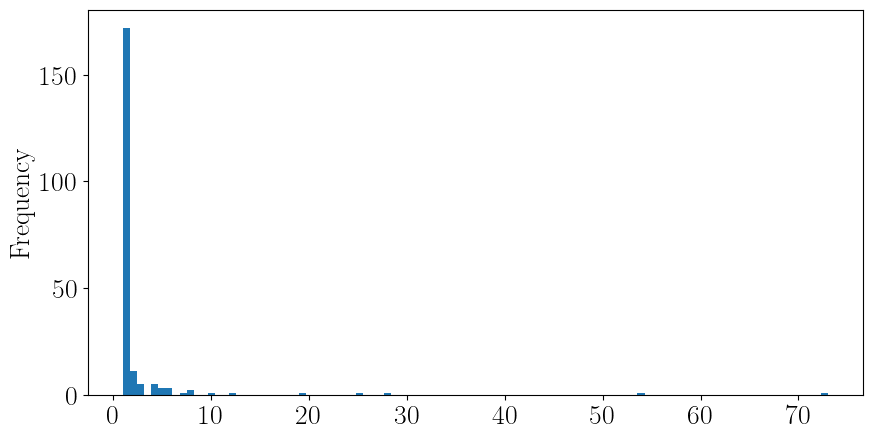

In [16]:
scaffold_df['count'].plot.hist(bins=100, figsize=(10, 5))

In [15]:
scaffold_dict = dict(zip(scaffold_df.scaffold,scaffold_df.index))
df['scaffold_idx'] = [scaffold_dict[x] for x in df.framework]

In [18]:
scaffold_df['mol'] = scaffold_df['scaffold'].apply(Chem.MolFromSmiles)
crds_ok = scaffold_df.mol.progress_apply(AllChem.Compute2DCoords)

100%|██████████| 134/134 [00:00<00:00, 5169.82it/s]


In [19]:
for idx, scaf in tqdm(scaffold_df[["scaffold_idx","mol"]].values):
    match_df = df.query("scaffold_idx == @idx")
    for mol in match_df.mol:
        AllChem.GenerateDepictionMatching2DStructure(mol,scaf)

100%|██████████| 134/134 [00:00<00:00, 754.81it/s]


In [24]:
# set the size of the structures in both grids
structure_size=(195,195)
# in order to do display an output from the callback, we need to instantiate an
# instance of widgets.Ouput().  Note that the final call in this cell displays
# "output"
output = widgets.Output()
@output.capture(clear_output=True, wait=True)
def show_details(data):
    idx = int(data["scaffold_idx"])
    detail_df = df.query("scaffold_idx == @idx")
    cols_to_display = ["SMILES","pIC50","mol"]
    detail_grid = mols2grid.MolGrid(detail_df, mol_col="mol",name=f"details_{idx}",size=structure_size)
    detail_view = detail_grid.display(n_rows=2,n_cols=4,subset=["img","label"],selection=False)
    display(detail_view)


# define the grid to show the scafffolds
scaffold_grid = mols2grid.MolGrid(scaffold_df, name="centers",mol_col="mol",size=structure_size)
scaffold_view = scaffold_grid.display(n_rows=2,
                                    n_cols=4,
                                    subset=["img","count","scaffold_idx"],
                                    selection=True,
                                    callback=show_details)
display(scaffold_view)
# show the detail grid
output

MolGridWidget(grid_id='centers')

Output()

In [23]:
df

,smiles,label,framework,mol,Natom,scaffold_idx
0,Cc1nc(C2CCCCC2)c2c3cc[nH]c3ncn12,False,c1cc2c(ncn3cnc(C4CCCCC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",37,37
1,c1cc2c(ncn3cnc(C4CCCCC4)c23)[nH]1,True,c1cc2c(ncn3cnc(C4CCCCC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",34,37
2,O=C(OCc1ccccc1)N1CCCC(c2ncn3cnc4[nH]ccc4c23)C1,False,O=C(OCc1ccccc1)N1CCCC(c2ncn3cnc4[nH]ccc4c23)C1,"<img data-content=""rdkit/molecule"" src=""data:i...",49,120
3,N#CCC(=O)N1CCCC(c2ncn3cnc4[nH]ccc4c23)C1,True,c1cc2c(ncn3cnc(C4CCCNC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",39,106
4,Cc1ccccc1-c1nnn2cnc3[nH]ccc3c12,True,c1ccc(-c2nnn3cnc4[nH]ccc4c23)cc1,"<img data-content=""rdkit/molecule"" src=""data:i...",30,39
...,...,...,...,...,...,...
442,O=C(CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1)NCC(F)(F)F,False,c1cc2c(ncn3nnc(C4CCCCC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",46,0
443,N#CCNC(=O)CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,False,c1cc2c(ncn3nnc(C4CCCCC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",44,0
444,N#CCNC(=O)CC1CCC(c2nnn3cnc4[nH]ccc4c23)CC1,False,c1cc2c(ncn3nnc(C4CCCCC4)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",44,0
445,N#CC1CC12CCC(c1nnn3cnc4[nH]ccc4c13)CC2,True,c1cc2c(ncn3nnc(C4CCC5(CC4)CC5)c23)[nH]1,"<img data-content=""rdkit/molecule"" src=""data:i...",38,48


## TSNE and PCA Visualization of the dataset

In [38]:
chembl_id = 'CHEMBL2219001'
featurizer = "unimol"
dataset_path = os.path.join(FS_MOL_DATASET_PATH, "embeddings", f'{featurizer}_train.pkl')

# load the dataset
with open(dataset_path, "rb") as f:
    data = pickle.load(f)

df = data[chembl_id]

In [39]:
data.keys()

dict_keys(['CHEMBL1825378', 'CHEMBL2186145', 'CHEMBL2219001', 'CHEMBL1614055', 'CHEMBL763437', 'CHEMBL829401', 'CHEMBL1918239', 'CHEMBL2394377', 'CHEMBL1211789', 'CHEMBL2188262', 'CHEMBL2219213', 'CHEMBL3388443', 'CHEMBL2219025', 'CHEMBL815983', 'CHEMBL873996', 'CHEMBL826584', 'CHEMBL767077', 'CHEMBL890929', 'CHEMBL989987', 'CHEMBL4233573', 'CHEMBL766346', 'CHEMBL997740', 'CHEMBL3381247', 'CHEMBL3599705', 'CHEMBL2219108', 'CHEMBL832268', 'CHEMBL645451', 'CHEMBL2320636', 'CHEMBL1937974', 'CHEMBL666747', 'CHEMBL3826271', 'CHEMBL2343282', 'CHEMBL2219019', 'CHEMBL835746', 'CHEMBL4194240', 'CHEMBL1656353', 'CHEMBL887422', 'CHEMBL3761212', 'CHEMBL3705746', 'CHEMBL1839503', 'CHEMBL3889082', 'CHEMBL1061933', 'CHEMBL3269990', 'CHEMBL2395048', 'CHEMBL4057013', 'CHEMBL1061110', 'CHEMBL732300', 'CHEMBL2415510', 'CHEMBL856124', 'CHEMBL699303', 'CHEMBL620819', 'CHEMBL2219055', 'CHEMBL3096080', 'CHEMBL967900', 'CHEMBL3706081', 'CHEMBL1614399', 'CHEMBL2219140', 'CHEMBL4026983', 'CHEMBL1119016', 'CHEMB

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 157 samples in 0.000s...
[t-SNE] Computed neighbors for 157 samples in 0.002s...
[t-SNE] Computed conditional probabilities for sample 157 / 157
[t-SNE] Mean sigma: 1.936468
[t-SNE] KL divergence after 250 iterations with early exaggeration: 60.423218
[t-SNE] KL divergence after 1000 iterations: 0.615140


/tmp/ipykernel_261738/784955266.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x="component-1", y="component-2", hue=tsne_df.y.tolist(),


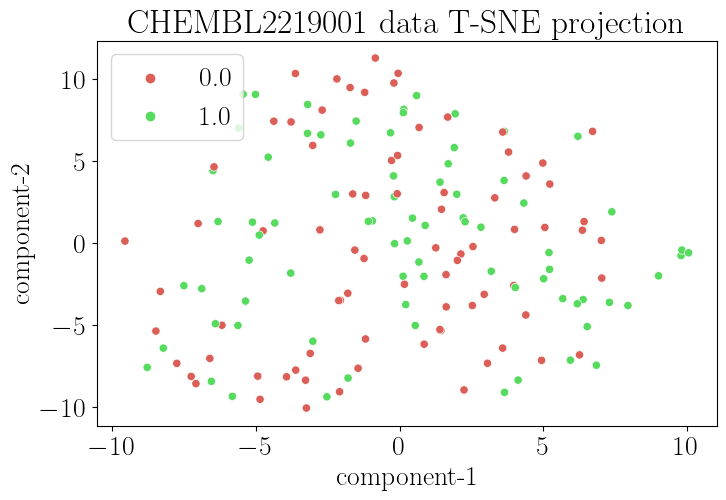

In [40]:
tsne = TSNE(n_components=2, verbose=1, random_state=123)
features = pd.DataFrame(df[featurizer]).astype(float).fillna(0)
z = tsne.fit_transform(features)

tsne_df = pd.DataFrame()
tsne_df["y"] = df['labels'].tolist()
tsne_df["component-1"] = z[:,0]
tsne_df["component-2"] = z[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(x="component-1", y="component-2", hue=tsne_df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=tsne_df).set(title=f"{chembl_id} data T-SNE projection") 
plt.show()

/tmp/ipykernel_261738/1914987182.py:11: UserWarning: The palette list has more values (3) than needed (2), which may not be intended.
  sns.scatterplot(x="component-1", y="component-2", hue=pca_df.y.tolist(),


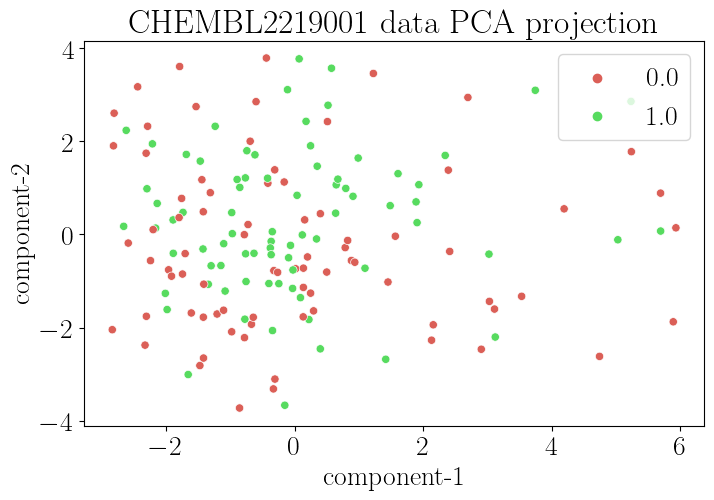

In [41]:
pca = PCA(n_components=2, random_state=123)
#features = pd.DataFrame(features).astype(float).fillna(0)
z = pca.fit_transform(df[featurizer])

pca_df = pd.DataFrame()
pca_df["y"] = df['labels'].tolist()
pca_df["component-1"] = z[:,0]
pca_df["component-2"] = z[:,1]

plt.figure(figsize=(8,5))
sns.scatterplot(x="component-1", y="component-2", hue=pca_df.y.tolist(),
                palette=sns.color_palette("hls", 3),
                data=pca_df).set(title=f"{chembl_id} data PCA projection") 
plt.show()

In [17]:
pca.explained_variance_ratio_

array([0.87478668, 0.0481601 ])

## Correlation between Meta-Learning Performance (different methods, different support sizes)

In [3]:
results_path = os.path.join(FS_MOL_CHECKOUT_PATH, "outputs")

# a dictionary summarising all models to be compared. Add new paths here as desired.
model_summaries_ProtoNet = {
    "ProtoNet_16": os.path.join(results_path, "FSMol_Eval_ProtoNet_2023-02-15_12-21-54", "summary", "ProtoNet_summary_num_train_requested_16.csv"),
    "ProtoNet_32": os.path.join(results_path, "FSMol_Eval_ProtoNet_2023-02-15_12-21-54", "summary", "ProtoNet_summary_num_train_requested_32.csv"),
    "ProtoNet_64": os.path.join(results_path, "FSMol_Eval_ProtoNet_2023-02-15_12-21-54", "summary", "ProtoNet_summary_num_train_requested_64.csv"),
    "ProtoNet_128": os.path.join(results_path, "FSMol_Eval_ProtoNet_2023-02-15_12-21-54", "summary", "ProtoNet_summary_num_train_requested_128.csv"),
    "ProtoNet_256": os.path.join(results_path, "FSMol_Eval_ProtoNet_2023-02-15_12-21-54", "summary", "ProtoNet_summary_num_train_requested_256.csv"),
}

model_summaries_MAML = {
    "MAML_16": os.path.join(results_path, "FSMol_Eval_MAML_2023-02-17_14-14-19", "summary", "MAML_summary_num_train_requested_16.csv"),
    "MAML_32": os.path.join(results_path, "FSMol_Eval_MAML_2023-02-17_14-14-19", "summary", "MAML_summary_num_train_requested_32.csv"),
    "MAML_64": os.path.join(results_path, "FSMol_Eval_MAML_2023-02-17_14-14-19", "summary", "MAML_summary_num_train_requested_64.csv"),
    "MAML_128": os.path.join(results_path, "FSMol_Eval_MAML_2023-02-17_14-14-19", "summary", "MAML_summary_num_train_requested_128.csv"),
    "MAML_256": os.path.join(results_path, "FSMol_Eval_MAML_2023-02-17_14-14-19", "summary", "MAML_summary_num_train_requested_256.csv"),
}

model_summaries_kNN = {
    "kNN_16": os.path.join(results_path, "FSMol_Eval_kNN_2023-01-31_14-35-49", "summary", "kNN_summary_num_train_requested_16.csv"),
    "kNN_32": os.path.join(results_path, "FSMol_Eval_kNN_2023-01-31_14-35-49", "summary", "kNN_summary_num_train_requested_32.csv"),
    "kNN_64": os.path.join(results_path, "FSMol_Eval_kNN_2023-01-31_14-35-49", "summary", "kNN_summary_num_train_requested_64.csv"),
    "kNN_128": os.path.join(results_path, "FSMol_Eval_kNN_2023-01-31_14-35-49", "summary", "kNN_summary_num_train_requested_128.csv"),
    "kNN_256": os.path.join(results_path, "FSMol_Eval_kNN_2023-01-31_14-35-49", "summary", "kNN_summary_num_train_requested_256.csv"),
}

model_summaries_randomForest = {
    "randomForest_16": os.path.join(results_path, "FSMol_Eval_randomForest_2023-02-15_17-54-15", "summary", "randomForest_summary_num_train_requested_16.csv"),
    "randomForest_32": os.path.join(results_path, "FSMol_Eval_randomForest_2023-02-15_17-54-15", "summary", "randomForest_summary_num_train_requested_32.csv"),
    "randomForest_64": os.path.join(results_path, "FSMol_Eval_randomForest_2023-02-15_17-54-15", "summary", "randomForest_summary_num_train_requested_64.csv"),
    "randomForest_128": os.path.join(results_path, "FSMol_Eval_randomForest_2023-02-15_17-54-15", "summary", "randomForest_summary_num_train_requested_128.csv"),
    "randomForest_256": os.path.join(results_path, "FSMol_Eval_randomForest_2023-02-15_17-54-15", "summary", "randomForest_summary_num_train_requested_256.csv"),
}

In [4]:
ProtoNet_16 = pd.read_csv(model_summaries_ProtoNet['ProtoNet_16'])
ProtoNet_32 = pd.read_csv(model_summaries_ProtoNet['ProtoNet_32'])
ProtoNet_64 = pd.read_csv(model_summaries_ProtoNet['ProtoNet_64'])
ProtoNet_128 = pd.read_csv(model_summaries_ProtoNet['ProtoNet_128'])
ProtoNet_256 = pd.read_csv(model_summaries_ProtoNet['ProtoNet_256'])

MAML_16 = pd.read_csv(model_summaries_MAML['MAML_16'])
MAML_32 = pd.read_csv(model_summaries_MAML['MAML_32'])
MAML_64 = pd.read_csv(model_summaries_MAML['MAML_64'])
MAML_128 = pd.read_csv(model_summaries_MAML['MAML_128'])
MAML_256 = pd.read_csv(model_summaries_MAML['MAML_256'])

kNN_16 = pd.read_csv(model_summaries_kNN['kNN_16'])
kNN_32 = pd.read_csv(model_summaries_kNN['kNN_32'])
kNN_64 = pd.read_csv(model_summaries_kNN['kNN_64'])
kNN_128 = pd.read_csv(model_summaries_kNN['kNN_128'])
kNN_256 = pd.read_csv(model_summaries_kNN['kNN_256'])

randomForest_16 = pd.read_csv(model_summaries_randomForest['randomForest_16'])
randomForest_32 = pd.read_csv(model_summaries_randomForest['randomForest_32'])
randomForest_64 = pd.read_csv(model_summaries_randomForest['randomForest_64'])
randomForest_128 = pd.read_csv(model_summaries_randomForest['randomForest_128'])
randomForest_256 = pd.read_csv(model_summaries_randomForest['randomForest_256'])

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.9379805349248582


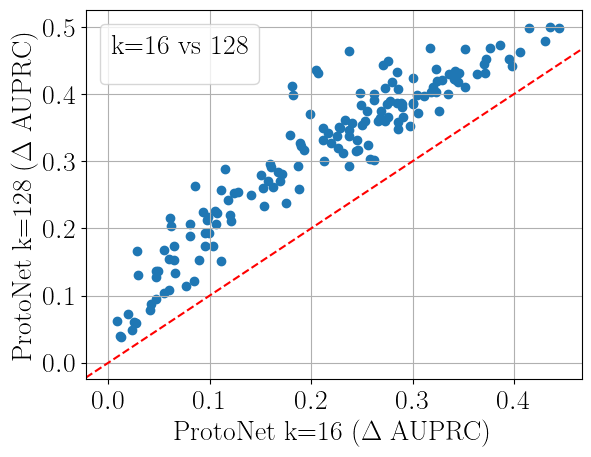

In [5]:
## Fixing Meta-Learning Model, Calculating correlation for different support sizes

print(ProtoNet_16['delta_auprc'].corr(ProtoNet_128['delta_auprc']))
fig, ax = plt.subplots()
ax.scatter(ProtoNet_16['delta_auprc'], ProtoNet_128['delta_auprc'])
ax.axline((0, 0), slope=1, color='red', linestyle='--')
ax.set_xlabel('ProtoNet k=16 ($\Delta$ AUPRC)')
ax.set_ylabel('ProtoNet k=128 ($\Delta$ AUPRC)')
ax.legend(title='k=16 vs 128', loc='upper left')
ax.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.8352910238603203


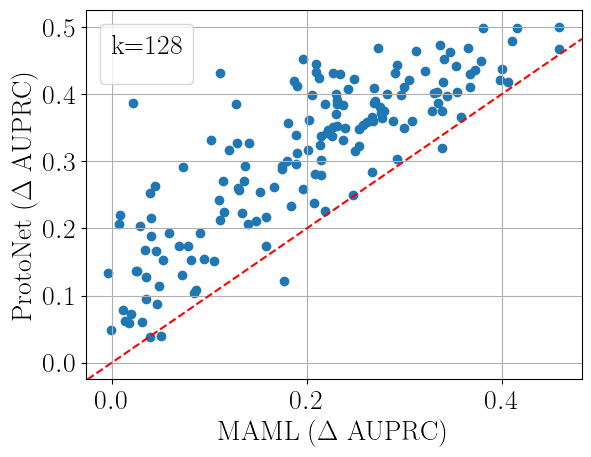

In [6]:
## Fixing Support sizes, Calculating correlation for different Meta-Learning algorithms (MAML and ProtoNet)

print(MAML_128['delta_auprc'].corr(ProtoNet_128['delta_auprc']))
fig, ax = plt.subplots()
ax.scatter(MAML_128['delta_auprc'], ProtoNet_128['delta_auprc'])
ax.axline((0, 0), slope=1, color='red', linestyle='--')
ax.set_xlabel('MAML ($\Delta$ AUPRC)')
ax.set_ylabel('ProtoNet ($\Delta$ AUPRC)')
ax.legend(title='k=128', loc='upper left')
ax.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6272649306155494


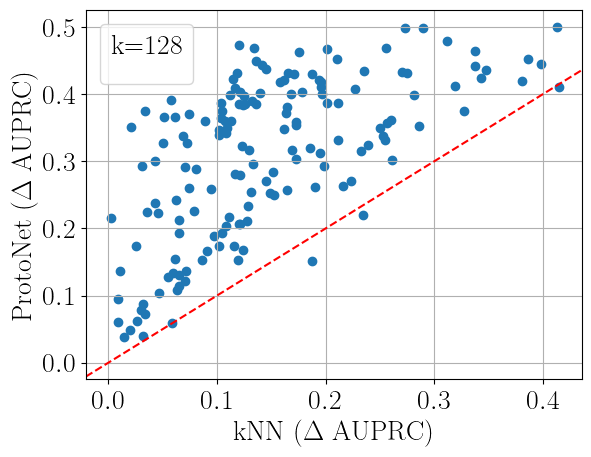

In [7]:
## Fixing Support sizes, Calculating correlation between ProtoNet (Meta-Learning) and kNN (single task method)

print(kNN_128['delta_auprc'].corr(ProtoNet_128['delta_auprc']))
fig, ax = plt.subplots()
ax.scatter(kNN_128['delta_auprc'], ProtoNet_128['delta_auprc'])
ax.axline((0, 0), slope=1, color='red', linestyle='--')
ax.set_xlabel('kNN ($\Delta$ AUPRC)')
ax.set_ylabel('ProtoNet ($\Delta$ AUPRC)')
ax.legend(title='k=128', loc='upper left')

ax.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.6334279100204973


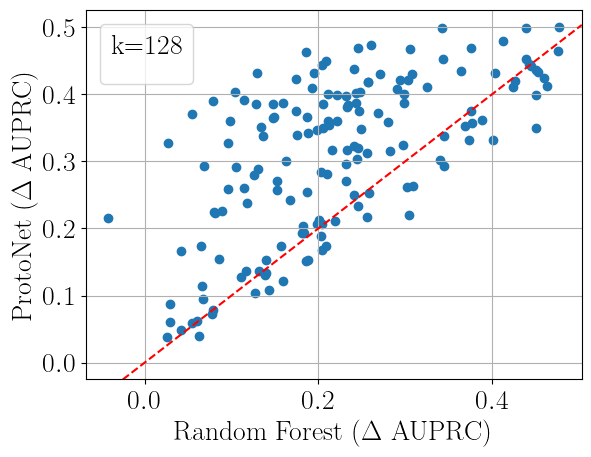

In [8]:
## Fixing Support sizes, Calculating correlation between ProtoNet (Meta-Learning) and randomForest (single task method)

print(randomForest_128['delta_auprc'].corr(ProtoNet_128['delta_auprc']))
fig, ax = plt.subplots()
ax.scatter(randomForest_128['delta_auprc'], ProtoNet_128['delta_auprc'])
ax.axline((0, 0), slope=1, color='red', linestyle='--')
ax.set_xlabel('Random Forest ($\Delta$ AUPRC)')
ax.set_ylabel('ProtoNet ($\Delta$ AUPRC)')
ax.legend(title='k=128', loc='upper left')
ax.grid()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.556


(0.4, 1.0)

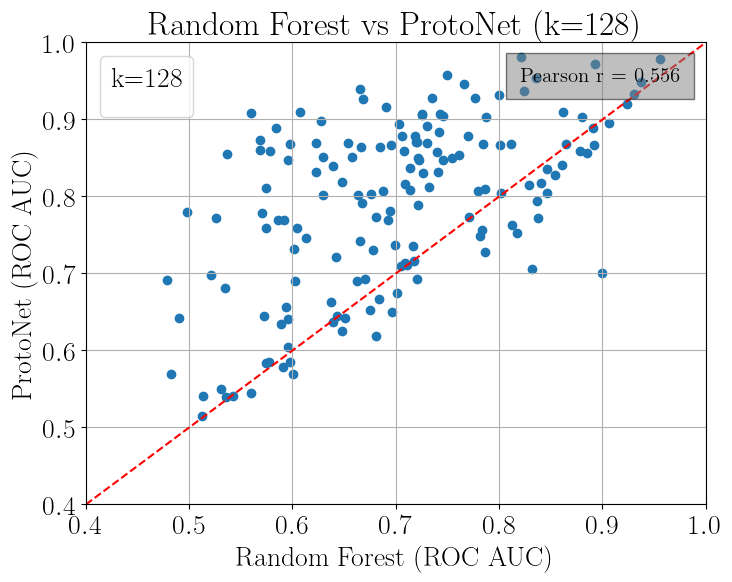

In [9]:
corr = randomForest_128['roc_auc'].corr(ProtoNet_128['roc_auc']).round(3)
print(corr)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(randomForest_128['roc_auc'], ProtoNet_128['roc_auc'])
ax.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax.set_title('Random Forest vs ProtoNet (k=128)')
ax.set_xlabel('Random Forest (ROC AUC)')
ax.set_ylabel('ProtoNet (ROC AUC)')
ax.legend(title='k=128', loc='upper left')
ax.grid()
#fig.savefig('assets/RF_ProtoNet.svg', format='svg')
ax.text(0.82, 0.95, 'Pearson r = {}'.format(corr), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)

ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


0.495


(0.4, 1.0)

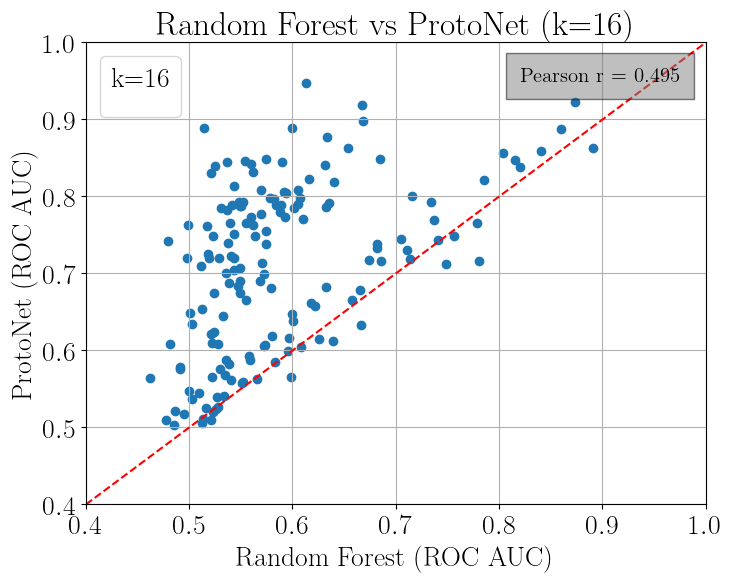

In [10]:
corr = randomForest_16['roc_auc'].corr(ProtoNet_16['roc_auc']).round(3)
print(corr)
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(randomForest_16['roc_auc'], ProtoNet_16['roc_auc'])
ax.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax.set_title('Random Forest vs ProtoNet (k=16)')
ax.set_xlabel('Random Forest (ROC AUC)')
ax.set_ylabel('ProtoNet (ROC AUC)')
ax.legend(title='k=16', loc='upper left')
ax.grid()
ax.text(0.82, 0.95, 'Pearson r = {}'.format(corr), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)

ax.set_xlim(0.4, 1)
ax.set_ylim(0.4, 1)

In [11]:
print((ProtoNet_16['roc_auc'] - randomForest_16['roc_auc']).mean())
print((ProtoNet_16['roc_auc'] - randomForest_16['roc_auc']).std())

0.12018109580374473
0.10131629967078269


In [12]:
ProtoNet_32['roc_auc'].corr(randomForest_32['roc_auc'], method='pearson')

0.5137610742173243

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


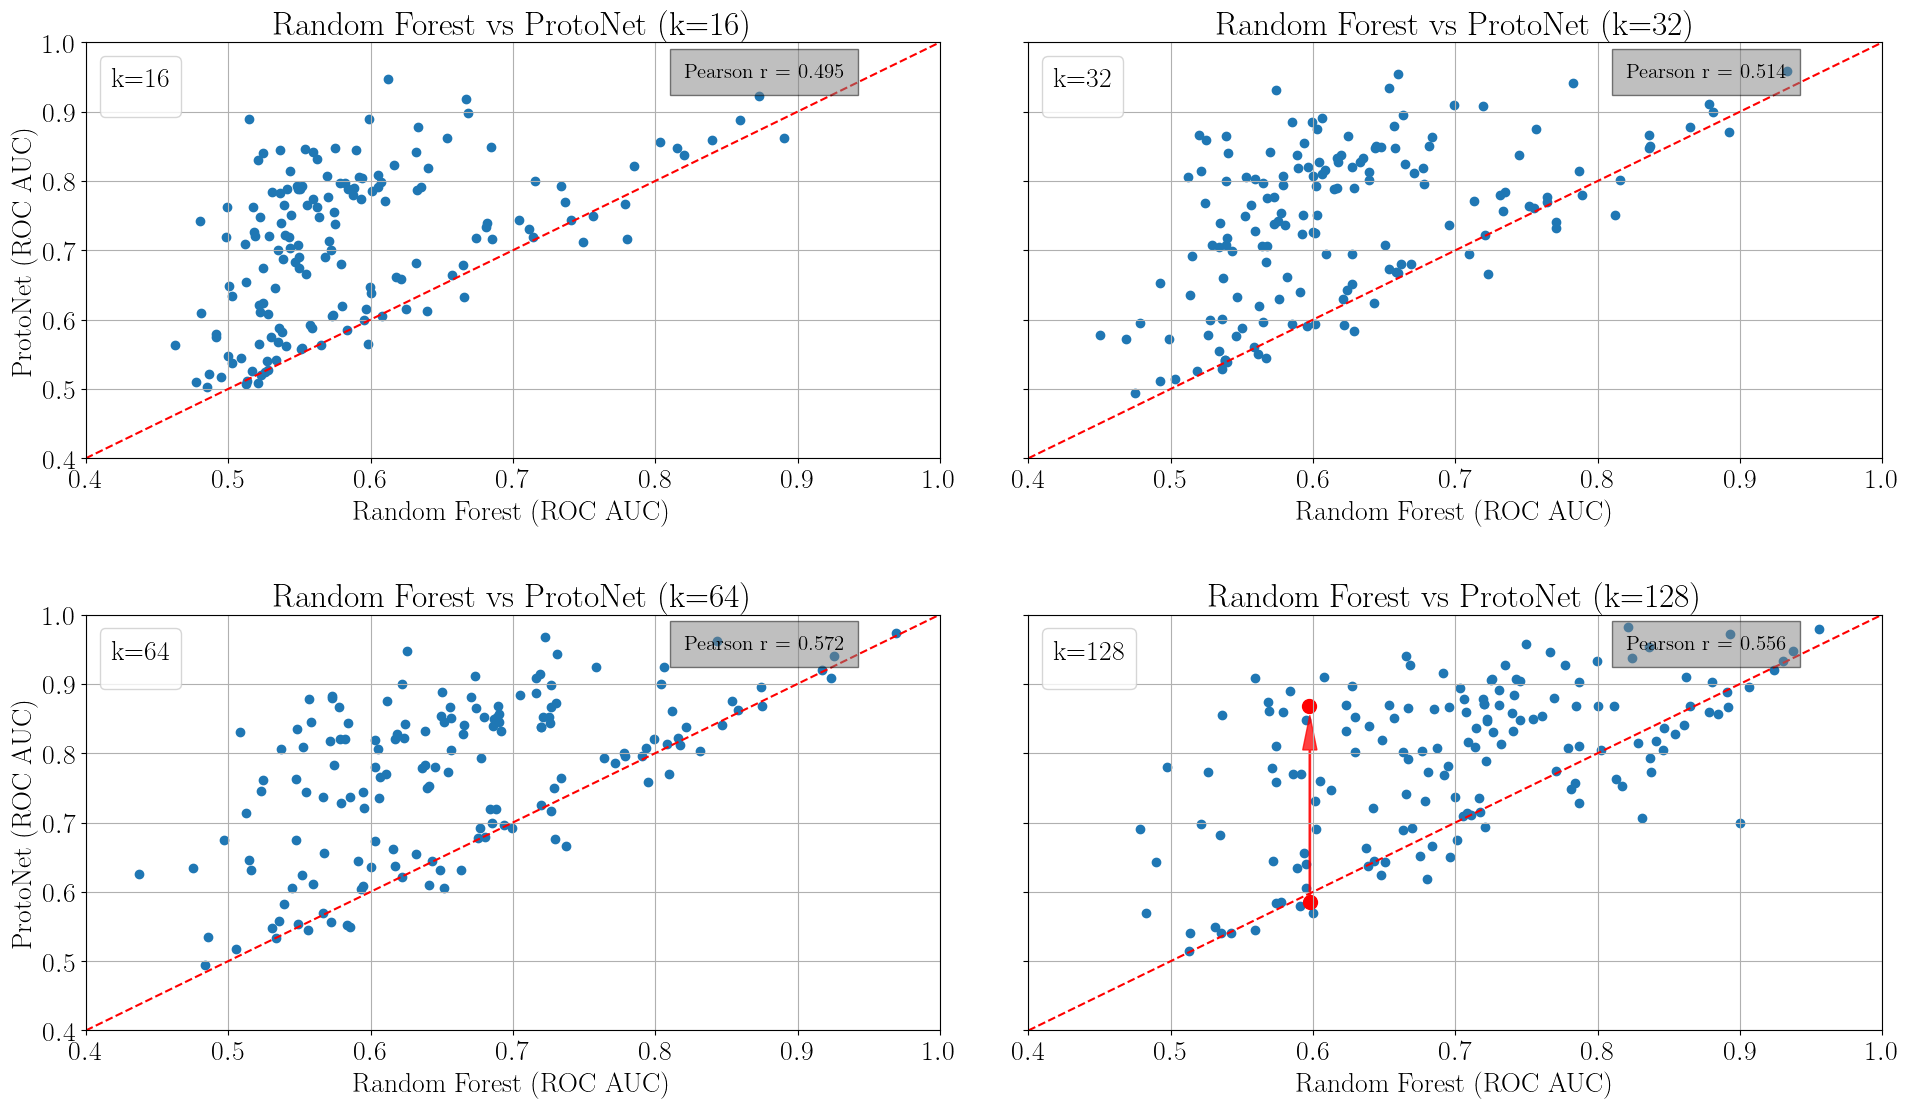

In [20]:
corr_16 = randomForest_16['roc_auc'].corr(ProtoNet_16['roc_auc']).round(3)
corr_32 = randomForest_32['roc_auc'].corr(ProtoNet_32['roc_auc']).round(3)
corr_64 = randomForest_64['roc_auc'].corr(ProtoNet_64['roc_auc']).round(3)
corr_128 = randomForest_128['roc_auc'].corr(ProtoNet_128['roc_auc']).round(3)


fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(20, 12), sharey=True)

ax0.scatter(randomForest_16['roc_auc'], ProtoNet_16['roc_auc'])
ax0.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax0.set_title('Random Forest vs ProtoNet (k=16)')
ax0.set_xlabel('Random Forest (ROC AUC)')
ax0.set_ylabel('ProtoNet (ROC AUC)')
ax0.legend(title='k=16', loc='upper left')
ax0.grid()
ax0.text(0.82, 0.95, 'Pearson r = {}'.format(corr_16), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax0.set_xlim(0.4, 1)
ax0.set_ylim(0.4, 1)

ax1.scatter(randomForest_32['roc_auc'], ProtoNet_32['roc_auc'])
ax1.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax1.set_title('Random Forest vs ProtoNet (k=32)')
ax1.set_xlabel('Random Forest (ROC AUC)')
#ax1.set_ylabel('ProtoNet (ROC AUC)')
ax1.legend(title='k=32', loc='upper left')
ax1.grid()
ax1.text(0.82, 0.95, 'Pearson r = {}'.format(corr_32), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax1.set_xlim(0.4, 1)
ax1.set_ylim(0.4, 1)


ax2.scatter(randomForest_64['roc_auc'], ProtoNet_64['roc_auc'])
ax2.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax2.set_title('Random Forest vs ProtoNet (k=64)')
ax2.set_xlabel('Random Forest (ROC AUC)')
ax2.set_ylabel('ProtoNet (ROC AUC)')
ax2.legend(title='k=64', loc='upper left')
ax2.grid()
ax2.text(0.82, 0.95, 'Pearson r = {}'.format(corr_64), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax2.set_xlim(0.4, 1)
ax2.set_ylim(0.4, 1)

ax3.scatter(randomForest_128['roc_auc'], ProtoNet_128['roc_auc'])
ax3.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax3.set_title('Random Forest vs ProtoNet (k=128)')
ax3.set_xlabel('Random Forest (ROC AUC)')
#ax3.set_ylabel('ProtoNet (ROC AUC)')
ax3.legend(title='k=128', loc='upper left')
ax3.grid()
ax3.text(0.82, 0.95, 'Pearson r = {}'.format(corr_128), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax3.set_xlim(0.4, 1)
ax3.set_ylim(0.4, 1)

## adding red points to the plot (to highlight points with the same RF and different ProtoNet performance)
ax3.scatter(randomForest_128['roc_auc'][[130, 81]], ProtoNet_128['roc_auc'][[130, 81]], color='red', s=100, marker='o')
ax3.arrow(randomForest_128['roc_auc'][130], ProtoNet_128['roc_auc'][130], 0, 0.22, head_width=0.01, head_length=0.05, fc='r', ec='r', alpha=0.75)

fig.tight_layout(pad=2.0)
fig.savefig('assets/RF_vs_ProtoNet.pdf', transparent=True, backend='pgf', bbox_inches='tight')

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


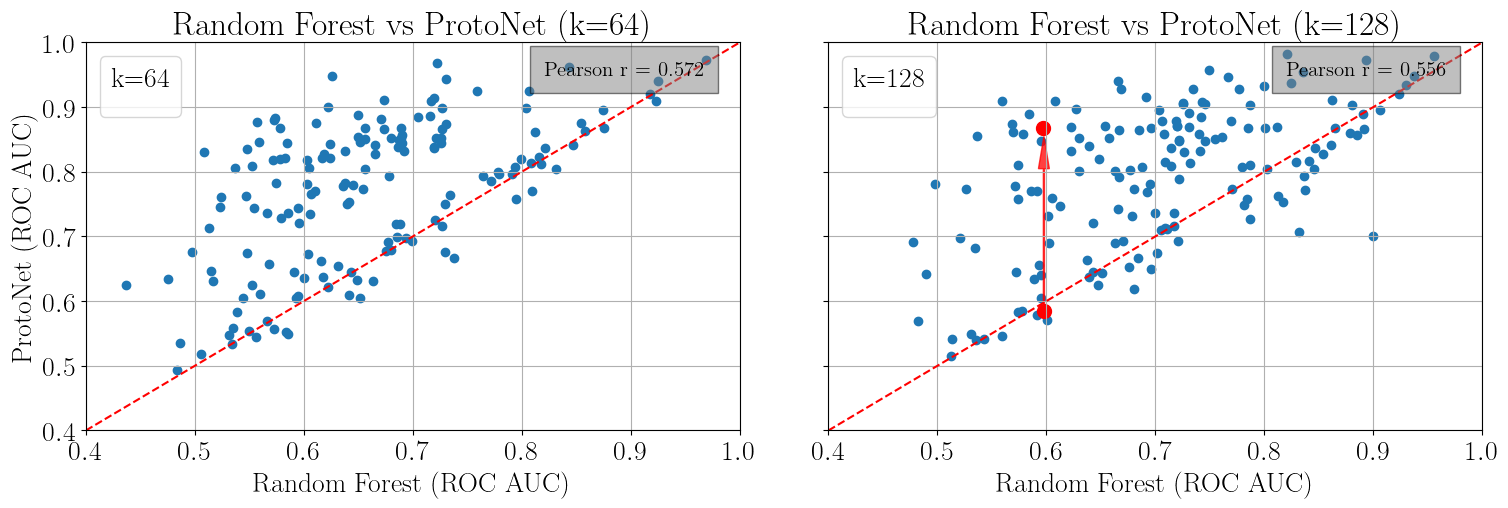

In [19]:
corr_16 = randomForest_16['roc_auc'].corr(ProtoNet_16['roc_auc']).round(3)
corr_32 = randomForest_32['roc_auc'].corr(ProtoNet_32['roc_auc']).round(3)
corr_64 = randomForest_64['roc_auc'].corr(ProtoNet_64['roc_auc']).round(3)
corr_128 = randomForest_128['roc_auc'].corr(ProtoNet_128['roc_auc']).round(3)


fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(16, 6), sharey=True)
"""
ax0.scatter(randomForest_16['roc_auc'], ProtoNet_16['roc_auc'])
ax0.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax0.set_title('Random Forest vs ProtoNet (k=16)')
ax0.set_xlabel('Random Forest (ROC AUC)')
ax0.set_ylabel('ProtoNet (ROC AUC)')
ax0.legend(title='k=16', loc='upper left')
ax0.grid()
ax0.text(0.82, 0.95, 'Pearson r = {}'.format(corr_16), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax0.set_xlim(0.4, 1)
ax0.set_ylim(0.4, 1)

ax1.scatter(randomForest_32['roc_auc'], ProtoNet_32['roc_auc'])
ax1.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax1.set_title('Random Forest vs ProtoNet (k=32)')
ax1.set_xlabel('Random Forest (ROC AUC)')
#ax1.set_ylabel('ProtoNet (ROC AUC)')
ax1.legend(title='k=32', loc='upper left')
ax1.grid()
ax1.text(0.82, 0.95, 'Pearson r = {}'.format(corr_32), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax1.set_xlim(0.4, 1)
ax1.set_ylim(0.4, 1)
"""

ax2.scatter(randomForest_64['roc_auc'], ProtoNet_64['roc_auc'])
ax2.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax2.set_title('Random Forest vs ProtoNet (k=64)')
ax2.set_xlabel('Random Forest (ROC AUC)')
ax2.set_ylabel('ProtoNet (ROC AUC)')
ax2.legend(title='k=64', loc='upper left')
ax2.grid()
ax2.text(0.82, 0.95, 'Pearson r = {}'.format(corr_64), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax2.set_xlim(0.4, 1)
ax2.set_ylim(0.4, 1)

ax3.scatter(randomForest_128['roc_auc'], ProtoNet_128['roc_auc'])
ax3.axline((0.5, 0.5), slope=1, color='red', linestyle='--')
ax3.set_title('Random Forest vs ProtoNet (k=128)')
ax3.set_xlabel('Random Forest (ROC AUC)')
#ax3.set_ylabel('ProtoNet (ROC AUC)')
ax3.legend(title='k=128', loc='upper left')
ax3.grid()
ax3.text(0.82, 0.95, 'Pearson r = {}'.format(corr_128), style='italic', bbox={
        'facecolor': 'grey', 'alpha': 0.5, 'pad': 10}, fontsize=15)
ax3.set_xlim(0.4, 1)
ax3.set_ylim(0.4, 1)

## adding red points to the plot (to highlight points with the same RF and different ProtoNet performance)
ax3.scatter(randomForest_128['roc_auc'][[130, 81]], ProtoNet_128['roc_auc'][[130, 81]], color='red', s=100, marker='o')
ax3.arrow(randomForest_128['roc_auc'][130], ProtoNet_128['roc_auc'][130], 0, 0.22, head_width=0.01, head_length=0.05, fc='r', ec='r', alpha=0.75)

fig.tight_layout(pad=2.0)
fig.savefig('assets/RF_vs_ProtoNet.pdf', transparent=True, backend='pgf', bbox_inches='tight')

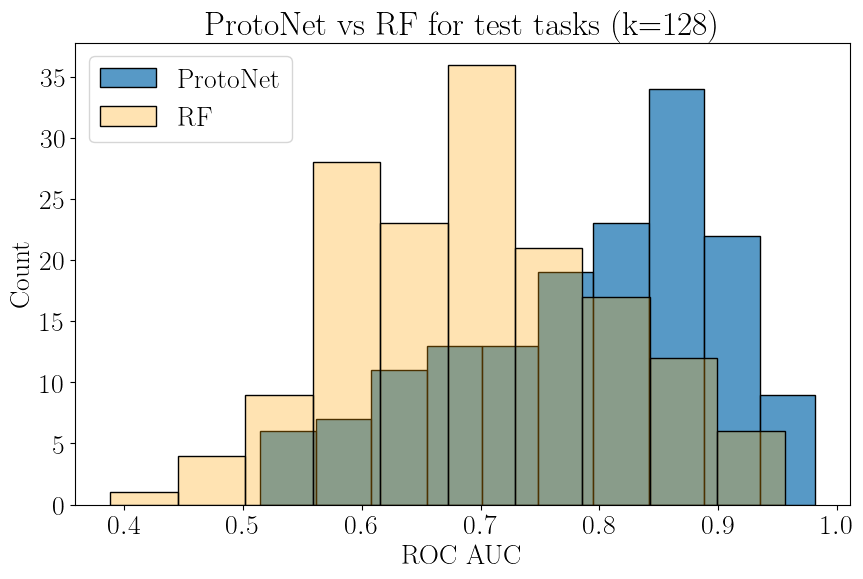

In [18]:
final_df = pd.merge(ProtoNet_128[['assay', 'roc_auc', 'delta_auprc']], randomForest_128[['assay', 'roc_auc', 'delta_auprc']], on='assay', suffixes=('_PN', '_RF'))

fig, ax = plt.subplots(figsize=(10, 6))
sns.histplot(data=final_df, x='roc_auc_PN', bins=10, ax=ax, legend=True, label='ProtoNet')
sns.histplot(data=final_df, x='roc_auc_RF', bins=10, alpha=0.3, color = 'orange', ax=ax, legend=True, label='RF')

ax.set_title('ProtoNet vs RF for test tasks (k=128)')
ax.set_xlabel('ROC AUC')
ax.set_ylabel('Count')

ax.legend(loc='upper left')
#fig.savefig('assets/hist_RF_ProtoNet.svg', format='svg', dpi=1200)
plt.show()

In [16]:
print(randomForest_16['roc_auc'].mean())
print(ProtoNet_16['roc_auc'].mean())


0.589067230926207
0.7092483267299518


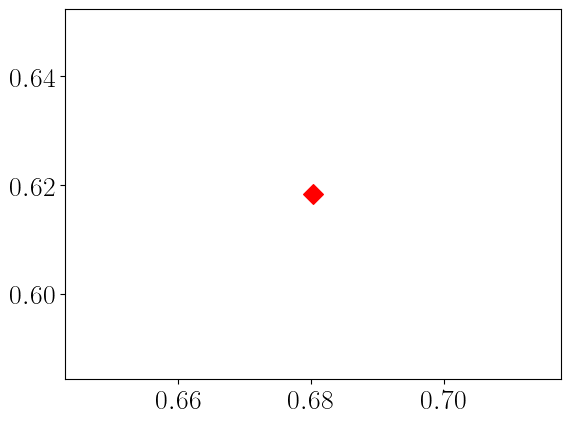

In [38]:
plt.scatter(randomForest_128['roc_auc'][0], ProtoNet_128['roc_auc'][0], color='red', s=100, marker='D')


In [63]:
randomForest_128['roc_auc'][((randomForest_128['roc_auc']>0.59) & (randomForest_128['roc_auc'] <0.60))]

15     0.593472
26     0.591110
29     0.595375
33     0.595200
77     0.595238
81     0.597143
122    0.591429
130    0.597732
Name: roc_auc, dtype: float64

In [68]:
((randomForest_128['roc_auc']>0.59) & (randomForest_128['roc_auc'] <0.60))

RangeIndex(start=0, stop=157, step=1)

In [69]:
ProtoNet_128['roc_auc'][[15, 26, 29, 33, 77, 81, 122, 130]]

15     0.656319
26     0.578996
29     0.605030
33     0.640562
77     0.847619
81     0.867619
122    0.769524
130    0.584688
Name: roc_auc, dtype: float64